# Bottom age tracer in the OM3-25km beta release

In [ ]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of another type.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
# needed for mkmd STOP

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/x77/wgh581/access-om3-paper-figs/


In [2]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from distributed import Client

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1) 
print(client.dashboard_link)

/proxy/8787/status


Open intake datastore:

In [4]:
# datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

6 Aug 2025: Output available from 1900-1948

### Load OM3-25km bottom age tracer

In [5]:
age_OM3 = datastore.search(variable="agessc", frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        # chunks={"time": -1}, # Good for temporal operations, but not spatial
        decode_timedelta=True
    )
)

In [6]:
age_OM3

<xarray.Dataset> Size: 340GB
Dimensions:  (time: 684, z_l: 75, yh: 1152, xh: 1440)
Coordinates:
  * time     (time) datetime64[ns] 5kB 1958-01-16T12:00:00 ... 2014-12-16T12:...
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yh       (yh) float64 9kB -81.58 -81.52 -81.45 -81.39 ... 89.74 89.84 89.95
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
Data variables:
    agessc   (time, z_l, yh, xh) float32 340GB dask.array<chunksize=(1, 75, 1152, 1440), meta=np.ndarray>
Attributes: (12/15)
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['agessc']
    intake_esm_attrs:file_id:                 ocean.1mon.nv:2.xh:1440.yh:1152...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ideal_age_tracer,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   area:mean z_l:mean yh:mean xh:m...
    intake_esm_attrs:variable_units:          yr,days,days since 1900-01-01 0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon.nv:2.xh:1440.yh:1152...

In [7]:
age_OM3_2014 = age_OM3.agessc.sel(yh=slice(-90,-50)).sel(time=slice('2014-01-01','2014-12-31'))
age_OM3_2014 = age_OM3_2014.mean('time').load()

In [12]:
# Get bottom tracer
depth_array = age_OM3_2014 * 0 + age_OM3_2014.z_l
max_depth   = depth_array.max(dim='z_l', skipna=True)

In [13]:
age_bot_2014 = age_OM3_2014.where(depth_array.z_l >= max_depth)
age_bot_2014 = age_bot_2014.sum(dim='z_l').load()

In [10]:
# Below code (using *10_yr and *50_yr) is from RYF simulation used previously for evaluation

In [32]:
# Year 10
# age_OM3_10yr = age_OM3.agessc.sel(yh=slice(-90,-50)).sel(time=slice('1909-01-01','1909-12-31'))
# age_OM3_10yr = age_OM3_10yr.mean('time').load()

In [33]:
# Year 50
# age_OM3_50yr = age_OM3.agessc.sel(yh=slice(-90,-50)).sel(time=slice('1950-01-01','1950-12-31')) # 1950 also avail for OM2-01
# age_OM3_50yr = age_OM3_50yr.mean('time').load()

In [34]:
# Get bottom tracer
# depth_array = age_OM3_10yr * 0 + age_OM3_10yr.z_l
# max_depth   = depth_array.max(dim='z_l', skipna=True)

In [35]:
# age_bot_10yr = age_OM3_10yr.where(depth_array.z_l >= max_depth)
# age_bot_10yr = age_bot_10yr.sum(dim='z_l').load()

In [36]:
# age_bot_50yr = age_OM3_50yr.where(depth_array.z_l >= max_depth)
# age_bot_50yr = age_bot_50yr.sum(dim='z_l').load()

Normalise age tracer by max value

In [14]:
age_bot_2014_normalised = age_bot_2014/age_bot_2014.max()

In [37]:
# age_bot_10yr_normalised = age_bot_10yr/age_bot_10yr.max()
# age_bot_50yr_normalised = age_bot_50yr/age_bot_50yr.max()

Mask contiental shelf

In [15]:
# Load shelf mask: 1000 m isobath for OM3-25km grid, created using this notebook: Calc_OM3_25km_1000m_isobath_contour.ipynb (add to repository?)
contour_masked_above = xr.open_mfdataset('/g/data/x77/wgh581/Post_Process/DSW_in_025_models/Antarctic_slope_contour_1000m_OM3_25km.nc').contour_masked_above

shelf_mask = contour_masked_above.where(contour_masked_above==0, 1)
shelf_mask = shelf_mask.where(shelf_mask==1)

In [18]:
age_bot_2014_masked = age_bot_2014_normalised*shelf_mask

In [40]:
# age_bot_10yr_masked = age_bot_10yr_normalised*shelf_mask
# age_bot_50yr_masked = age_bot_50yr_normalised*shelf_mask

### Compare to age tracer from OM2-01

Note there is no age tracer saved for OM2-025 (only for the first three years and then from 2300 onwards). OM2-01 has good DSW overflow and AABW formation so it makes sense to compare to that simulation.

In [39]:
catalog  = intake.cat.access_nri
expt_01 = '01deg_jra55v140_iaf' # cylc 1 of OM2-01 IAF simulation
# expt_01  = '01deg_jra55v13_ryf9091' # use for RYF comparison
# expt_025 = '025deg_jra55_ryf9091_gadi'

In [40]:
age_OM2_01 = catalog[expt_01].search(variable="age_global", frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        # chunks={"time": -1}, # Good for temporal operations, but not spatial
        decode_timedelta=True
    )
)

In [50]:
# Year 2014 
age_OM2_01_2014 = age_OM2_01.age_global.sel(yt_ocean=slice(-90,-50)).sel(time=slice('2014-01-01','2014-12-31'))
age_OM2_01_2014 = age_OM2_01_2014.mean('time').load()

In [8]:
# # Year 50 (use with 01deg_jra55v13_ryf9091 experiment)
# age_OM2_01_50yr = age_OM2_01.age_global.sel(yt_ocean=slice(-90,-50)).sel(time=slice('1950-01-01','1950-12-31'))
# age_OM2_01_50yr = age_OM2_01_50yr.mean('time').load()

In [51]:
# Get bottom tracer
depth_array_OM2_01 = age_OM2_01_2014 * 0 + age_OM2_01_2014.st_ocean
max_depth_OM2_01   = depth_array_OM2_01.max(dim='st_ocean', skipna=True)

In [52]:
age_bot_OM2_01_2014 = age_OM2_01_2014.where(depth_array_OM2_01.st_ocean >= max_depth_OM2_01)
age_bot_OM2_01_2014 = age_bot_OM2_01_2014.sum(dim='st_ocean').load()

In [53]:
# Normalise age tracer
age_bot_OM2_01_2014_normalised = age_bot_OM2_01_2014/age_bot_OM2_01_2014.max()

Mask continental shelf

In [30]:
contour_data  = np.load('/g/data/g40/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
contour_mask_numbered = contour_data['contour_mask_numbered']
contour_masked_above = contour_data['contour_masked_above']
contour_1000m = np.where(contour_mask_numbered == 0, contour_mask_numbered, 1000)
contour_xt_ocean = contour_data['xt_ocean']
contour_yt_ocean = contour_data['yt_ocean']

In [45]:
# Create dataset
ds = xr.Dataset(
    {
        "contour_1000m": (("yt_ocean", "xt_ocean"), contour_1000m),
        "contour_mask_numbered": (("yt_ocean", "xt_ocean"), contour_mask_numbered),
        "contour_masked_above": (("yt_ocean", "xt_ocean"), contour_masked_above),
    },
    coords={
        "xt_ocean": contour_xt_ocean,
        "yt_ocean": contour_yt_ocean,
    },
)

In [46]:
shelf_mask_01 = ds.contour_masked_above.where(ds.contour_masked_above==0, 1)
shelf_mask_01 = shelf_mask_01.where(shelf_mask_01==1)

In [54]:
age_bot_OM2_01_2014_masked = age_bot_OM2_01_2014_normalised*shelf_mask_01

### Plotting

In [16]:
# Land mask
var_search = datastore.search(variable="deptho")
ds = var_search.search(path=var_search.df.path[0]).to_dask() # we only need one file as bathymetry doesn't change
bathymetry = ds["deptho"].load()
land = xr.where(np.isnan(bathymetry.rename("land")), 1, np.nan)
land = land.sel(yh=slice(-90,-50))

ft_size = 12 # fontsize
fig_path = '/g/data/x77/wgh581/Figures/DSW_in_025_models/'

In [17]:
# 1000 m contour
slope_contour = contour_masked_above.where(contour_masked_above>0)
slope_contour = slope_contour/slope_contour

Plot MC_25km_jra_iaf-1.0-beta-5165c0f8 and 01deg_jra55v140_iaf (year 2014)

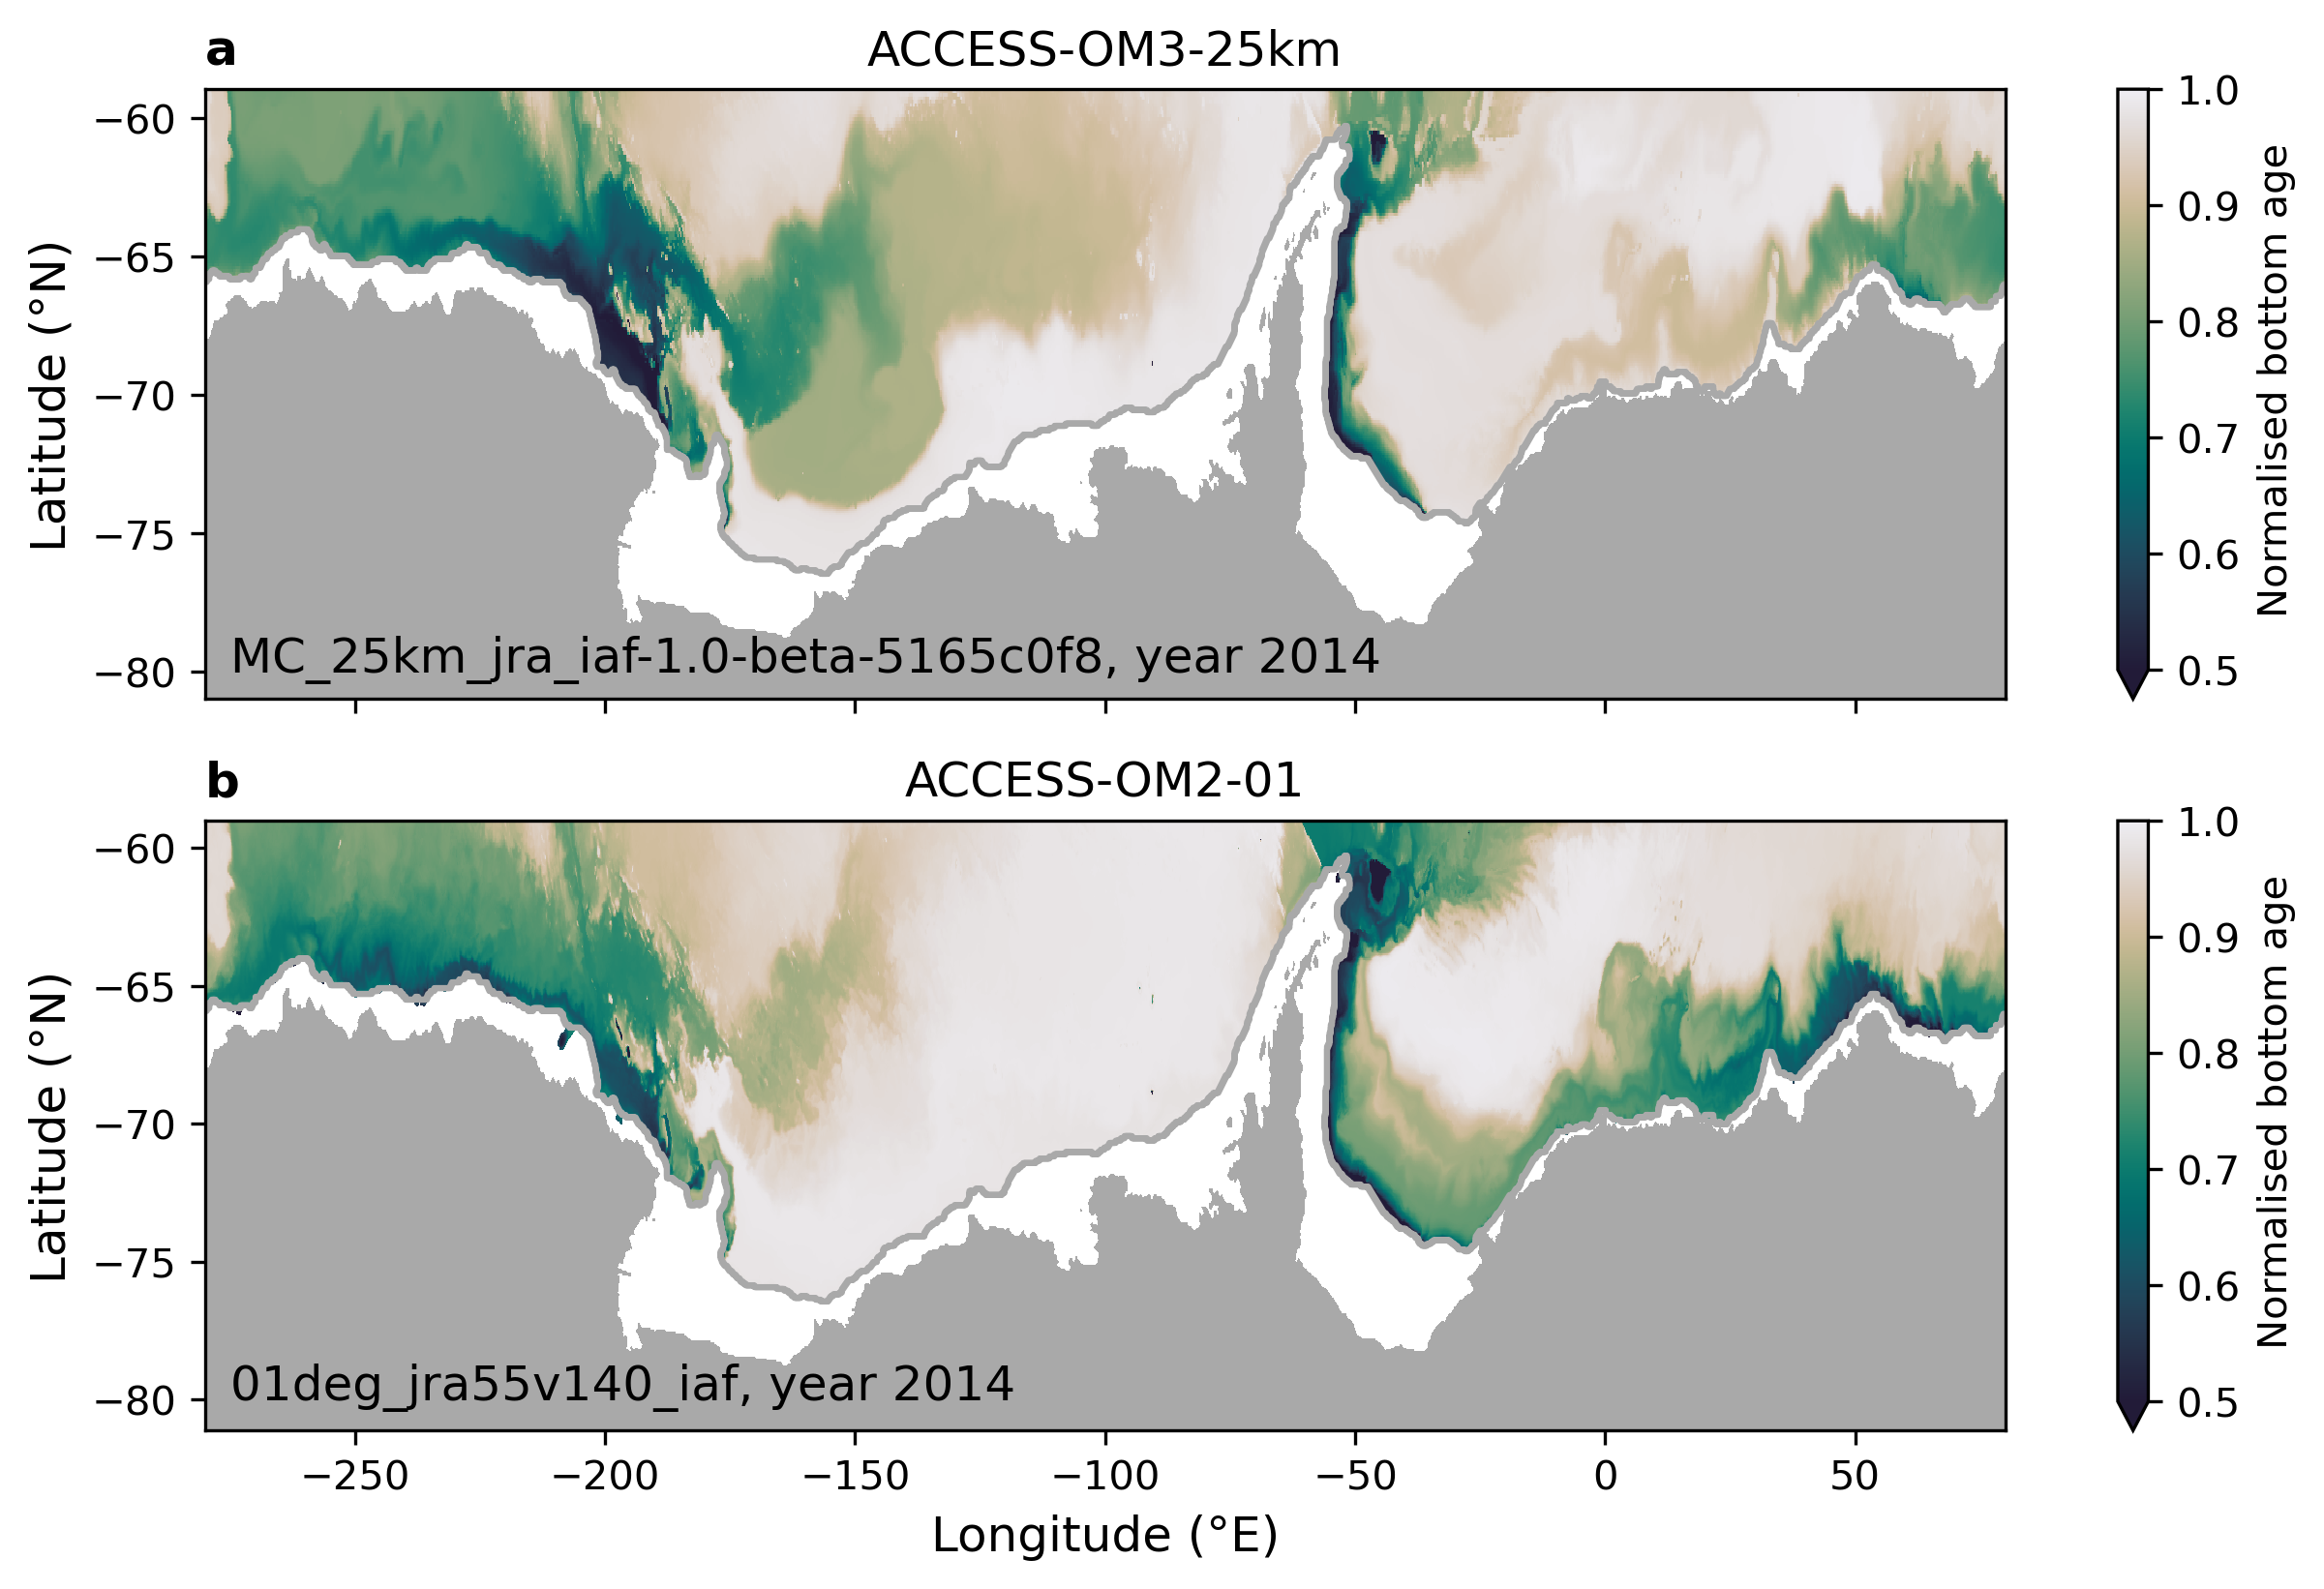

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(211)
land.plot.contourf(colors="darkgrey", add_colorbar=False)
age_bot_2014_masked.plot(cmap=cm.cm.rain_r, vmin=0.5, vmax=1, cbar_kwargs={'label': "Normalised bottom age"})
slope_contour.fillna(2).plot.contour(levels=[0,1], colors='darkgrey', linewidths=1.5)
plt.title('ACCESS-OM3-25km'), plt.title('a', fontweight='bold', fontsize=ft_size, loc='left')
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel('Latitude (°N)', fontsize=ft_size)
plt.text(-275, -80, 'MC_25km_jra_iaf-1.0-beta-5165c0f8, year 2014', fontsize=ft_size)

plt.subplot(212)
land.plot.contourf(colors="darkgrey", add_colorbar=False)
age_bot_OM2_01_2014_masked.plot(cmap=cm.cm.rain_r, vmin=0.5, vmax=1, cbar_kwargs={'label': "Normalised bottom age"})
slope_contour.fillna(2).plot.contour(levels=[0,1], colors='darkgrey', linewidths=1.5)
plt.title('ACCESS-OM2-01'), plt.title('b', fontweight='bold', fontsize=ft_size, loc='left')
plt.xlabel('Longitude (°E)', fontsize=ft_size), plt.ylabel('Latitude (°N)', fontsize=ft_size)
plt.text(-275, -80, '01deg_jra55v140_iaf, year 2014', fontsize=ft_size)

# Save figure
save_flag = 1
if save_flag == 1:
    plt.savefig(fig_path + 'Fig_bottom_age_MC_25km_jra_iaf-1.0-beta-5165c0f8_01deg_jra55v140_iaf_year2014.png', dpi=300, bbox_inches='tight', facecolor='white');

plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')

In [ ]:
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
mkmd("Bottom age tracer","`"+notebook_name+"`: Normalised bottom age comparing ACCESS-OM3 and ACCESS-OM2.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')

---

### Plots from previous RYF simulation

Plot OM3-25km at years 10 and 50

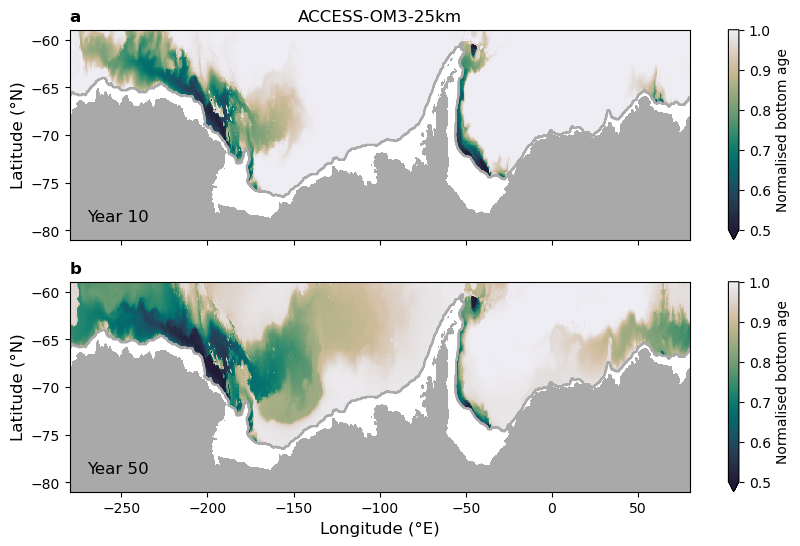

In [55]:
plt.figure(figsize=(10, 6))

plt.subplot(211)
land.plot.contourf(colors="darkgrey", add_colorbar=False)
age_bot_10yr_masked.plot(cmap=cm.cm.rain_r, vmin=0.5, vmax=1, cbar_kwargs={'label': "Normalised bottom age"})
slope_contour.fillna(2).plot.contour(levels=[0,1], colors='darkgrey', linewidths=1.5)
plt.title('ACCESS-OM3-25km'), plt.title('a', fontweight='bold', fontsize=ft_size, loc='left')
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel('Latitude (°N)', fontsize=ft_size)
plt.text(-270, -79, 'Year 10', fontsize=ft_size)

plt.subplot(212)
land.plot.contourf(colors="darkgrey", add_colorbar=False)
age_bot_50yr_masked.plot(cmap=cm.cm.rain_r, vmin=0.5, vmax=1, cbar_kwargs={'label': "Normalised bottom age"})
slope_contour.fillna(2).plot.contour(levels=[0,1], colors='darkgrey', linewidths=1.5)
plt.title('b', fontweight='bold', fontsize=ft_size, loc='left')
plt.xlabel('Longitude (°E)', fontsize=ft_size), plt.ylabel('Latitude (°N)', fontsize=ft_size)
plt.text(-270, -79, 'Year 50', fontsize=ft_size)

# Save figure
save_flag = 1
if save_flag == 1:
    plt.savefig(fig_path + 'Fig_bottom_age_OM325km_yr10_yr50.png', dpi=300, bbox_inches='tight', facecolor='white');

Things to note:
- DSW overflow occurs mainly in the Ross Sea and also in the Weddell Sea
- No overflow in Adelie land (see pale yellow line that interrupts the young shelf waters from the young-ish offshore waters fed by the Ross Sea)
- Little overflow in Prydz Bay
- The young bottom waters offshore of the Antarctic continental shelf seem to be from DSW export. Deep open ocean convection - which often occurs in 0.25deg models - does not seem to impact Antarctic Bottom Water formation in OM3-25 km. This is great news! (Compare the mixed layer depth maps which show (i) very shallow maximum winter mixed layer depths and (ii) the pattern of young offshore age tracer does not align with where there are deeper mixed layers.)

Plot OM3-25km together with OM2-01

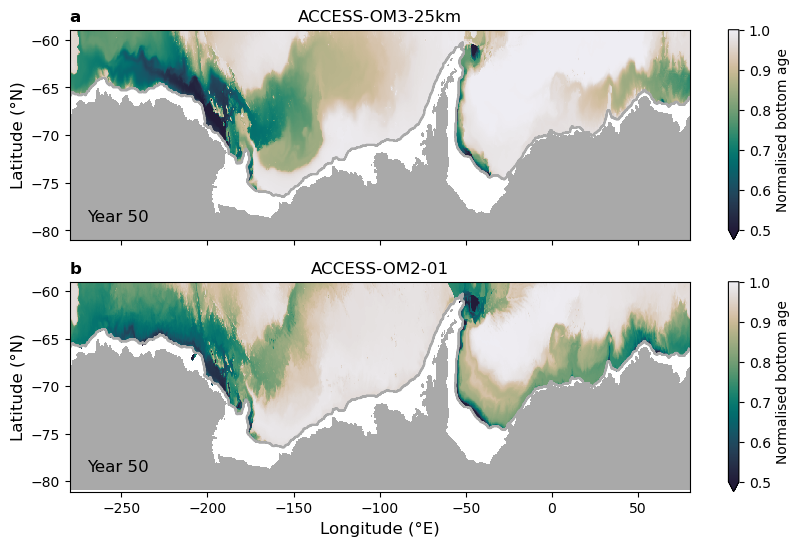

In [56]:
plt.figure(figsize=(10, 6))

plt.subplot(211)
land.plot.contourf(colors="darkgrey", add_colorbar=False)
age_bot_50yr_masked.plot(cmap=cm.cm.rain_r, vmin=0.5, vmax=1, cbar_kwargs={'label': "Normalised bottom age"})
slope_contour.fillna(2).plot.contour(levels=[0,1], colors='darkgrey', linewidths=1.5)
plt.title('ACCESS-OM3-25km'), plt.title('a', fontweight='bold', fontsize=ft_size, loc='left')
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel('Latitude (°N)', fontsize=ft_size)
plt.text(-270, -79, 'Year 50', fontsize=ft_size)

plt.subplot(212)
land.plot.contourf(colors="darkgrey", add_colorbar=False)
age_bot_OM2_01_50yr_masked.plot(cmap=cm.cm.rain_r, vmin=0.5, vmax=1, cbar_kwargs={'label': "Normalised bottom age"})
slope_contour.fillna(2).plot.contour(levels=[0,1], colors='darkgrey', linewidths=1.5)
plt.title('ACCESS-OM2-01'), plt.title('b', fontweight='bold', fontsize=ft_size, loc='left')
plt.xlabel('Longitude (°E)', fontsize=ft_size), plt.ylabel('Latitude (°N)', fontsize=ft_size)
plt.text(-270, -79, 'Year 50', fontsize=ft_size)

# Save figure
save_flag = 1
if save_flag == 1:
    plt.savefig(fig_path + 'Fig_bottom_age_OM325km_OM201_yr50.png', dpi=300, bbox_inches='tight', facecolor='white');